# 🤖 12-State Nonlinear Robot Model Documentation

## 📌 Model Overview

This simulation models a **nonlinear 3-DOF robotic manipulator** with **12 continuous states**, inspired by a 3-link serial robot arm (e.g. UR3, KUKA LBR). It includes both the mechanical joint dynamics and internal actuator behavior.

---

## 🧮 State Vector

The state vector is defined as:

$$
\mathbf{x} =
\begin{bmatrix}
\theta_1 \\
\theta_2 \\
\theta_3 \\
\dot{\theta}_1 \\
\dot{\theta}_2 \\
\dot{\theta}_3 \\
z_1 \\
z_2 \\
z_3 \\
\dot{z}_1 \\
\dot{z}_2 \\
\dot{z}_3
\end{bmatrix}
\in \mathbb{R}^{12}
$$

- \( \theta_i \): joint angles  
- \( \dot{\theta}_i \): joint velocities  
- \( z_i \): internal actuator states  
- \( \dot{z}_i \): actuator state velocities

---

## ⚙️ Dynamics Equations

### 🔧 Manipulator Dynamics (Euler-Lagrange):

$$
M(\boldsymbol{\theta}) \ddot{\boldsymbol{\theta}} + C(\boldsymbol{\theta}, \dot{\boldsymbol{\theta}}) \dot{\boldsymbol{\theta}} + G(\boldsymbol{\theta}) = \boldsymbol{\tau}
$$

Where:

- \( M(\theta) \): inertia matrix (nonlinear, configuration-dependent)  
- \( C(\theta, \dot{\theta}) \): Coriolis matrix (simplified)  
- \( G(\theta) \): gravity vector  
- \( \tau = k \cdot \tanh(z - \theta) \): actuator torque

---

### ⚡ Actuator Dynamics (Second Order):

$$
\ddot{z}_i = -a \dot{z}_i - b \cdot \tanh(z_i - \theta_i) + u_i
$$

- \( a, b > 0 \): damping and stiffness terms  
- \( u_i \): external control input  
- \( \tanh(\cdot) \): smooth, bounded nonlinearity

---

## 🧠 Input Signal

The system receives an input:

$$
\mathbf{u}(t) = \begin{bmatrix}
u_1(t) \\
u_2(t) \\
u_3(t)
\end{bmatrix}
\in \mathbb{R}^3
$$

Inputs can be generated using parameterized signal classes:
- **GaussianSequence**: white noise inputs
- **SinusoidalSequence**: smooth oscillations
- Extendable to step, pulse, random walk, etc.

---

## 📈 Output & Plots

The simulation produces:
- Joint angles \( \theta_i(t) \)
- Joint velocities \( \dot{\theta}_i(t) \)
- Actuator states \( z_i(t) \)
- Inputs \( u_i(t) \)

These are plotted against time to analyze the system behavior.

---

## 📚 References

- Spong, M. W., Hutchinson, S., & Vidyasagar, M. (2006).  
  *Robot Modeling and Control*, Wiley.

- Craig, J. J. (2005).  
  *Introduction to Robotics: Mechanics and Control*, Pearson.

- Featherstone, R., & Orin, D. E. (2008).  
  *Dynamics of Robotic Systems*, in Springer Handbook of Robotics.

- Siciliano, B., Sciavicco, L., Villani, L., & Oriolo, G. (2009).  
  *Robotics: Modelling, Planning and Control*, Springer.

---

## ✅ Use Cases

- Control system design (e.g. MPC, LQR)  
- Reinforcement Learning environments  
- System identification / simulation  
- Testing of differentiable physics models


In [2]:
## Libriaries & Parameters
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Constants
a, b, k = 2.0, 5.0, 10.0
g = 9.81
m1, m2, m3 = 1.0, 1.0, 1.0
l1, l2, l3 = 1.0, 1.0, 1.0
T = 30

In [3]:
## Main code
# Base class for input signal generators
class SequenceGenerator:
    def __init__(self, dim, rng=None):
        self.dim = dim
        self._rng = rng if rng is not None else np.random.default_rng()

    def sample(self, time_range, delta):
        return self._sample_impl(time_range, delta)

    def _sample_impl(self, time_range, delta):
        raise NotImplementedError()

# Gaussian input sequence
   
class GaussianSqWave(SequenceGenerator):

    def __init__(self, period, mean=0., std=1., dim=1, rng=None):
        super().__init__(dim, rng)

        self._period = period
        self._mean = mean
        self._std = std

    def _sample_impl(self, time_range, delta):
        n_control_vals = int(1 +
                             np.floor((time_range[1] - time_range[0]) / delta))

        n_amplitude_vals = int(np.ceil(n_control_vals / self._period))

        amp_seq = self._rng.normal(loc=self._mean,
                                   scale=self._std,
                                   size=(n_amplitude_vals, self.dim))

        control_seq = np.repeat(amp_seq, self._period, axis=0)[:n_control_vals]
        return control_seq

# Sinusoidal input sequence
class SinusoidalSequence(SequenceGenerator):
    def __init__(self, max_freq=1.0, rng=None):
        super().__init__(1, rng)
        self._amp_mean = 1.0
        self._amp_std = 1.0
        self._mf = max_freq

    def _sample_impl(self, time_range, delta):
        amplitude = self._rng.lognormal(mean=self._amp_mean, sigma=self._amp_std)
        frequency = self._rng.uniform(0, self._mf)
        n_control_vals = int(1 + np.floor((time_range[1] - time_range[0]) / delta))
        time = np.linspace(time_range[0], time_range[1], n_control_vals)
        return (amplitude * np.sin(np.pi * frequency / delta * time)).reshape((-1, 1))

# Robot dynamics
def realistic_robot_dynamics(t, x, u):
    theta = x[0:3]
    dtheta = x[3:6]
    z = x[6:9]
    dz = x[9:12]

    M11 = m1*l1**2 + m2*(l1**2 + l2**2 + 2*l1*l2*np.cos(theta[1])) + m3*(l1**2 + l2**2 + l3**2)
    M12 = m2*(l2**2 + l1*l2*np.cos(theta[1])) + m3*(l2**2 + l3**2)
    M13 = m3*(l3**2)
    M = np.array([
        [M11, M12, M13],
        [M12, M12, M13],
        [M13, M13, M13]
    ])

    C = np.array([
        [-m2*l1*l2*np.sin(theta[1])*dtheta[1], 0, 0],
        [ m2*l1*l2*np.sin(theta[1])*dtheta[0], 0, 0],
        [0, 0, 0]
    ])

    G = np.array([
        (m1 + m2 + m3) * g * l1 * np.sin(theta[0]),
        (m2 + m3) * g * l2 * np.sin(theta[1]),
        m3 * g * l3 * np.sin(theta[2])
    ])

    tau = k * np.tanh(z - theta)
    ddtheta = np.linalg.inv(M) @ (tau - C @ dtheta - G)
    ddz = -a * dz - b * np.tanh(z - theta) + u

    return np.concatenate([dtheta, ddtheta, dz, ddz])

# Simulation wrapper
def simulate_realistic_input(input_sequence, t_span=(0, T), x0=None, delta=0.01):
    if x0 is None:
        x0 = np.zeros(12)
        x0[0:3] = np.array([0.1, -0.2, 0.05])

    control_inputs = input_sequence.sample(t_span, delta)

    def wrapped_dynamics(t, x):
        index = min(int((t - t_span[0]) / delta), len(control_inputs) - 1)
        u = np.tile(control_inputs[index], 3)  # same input to all actuators
        return realistic_robot_dynamics(t, x, u)

    sol = solve_ivp(wrapped_dynamics, t_span, x0, t_eval=np.linspace(*t_span, int((t_span[1] - t_span[0]) / delta)))
    return sol.t, sol.y

C:\Users\g7fie\AppData\Local\Temp\ipykernel_21852\4123842119.py:31: UserWarning: Glyph 120579 (\N{MATHEMATICAL ITALIC SMALL THETA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\g7fie\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 120579 (\N{MATHEMATICAL ITALIC SMALL THETA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


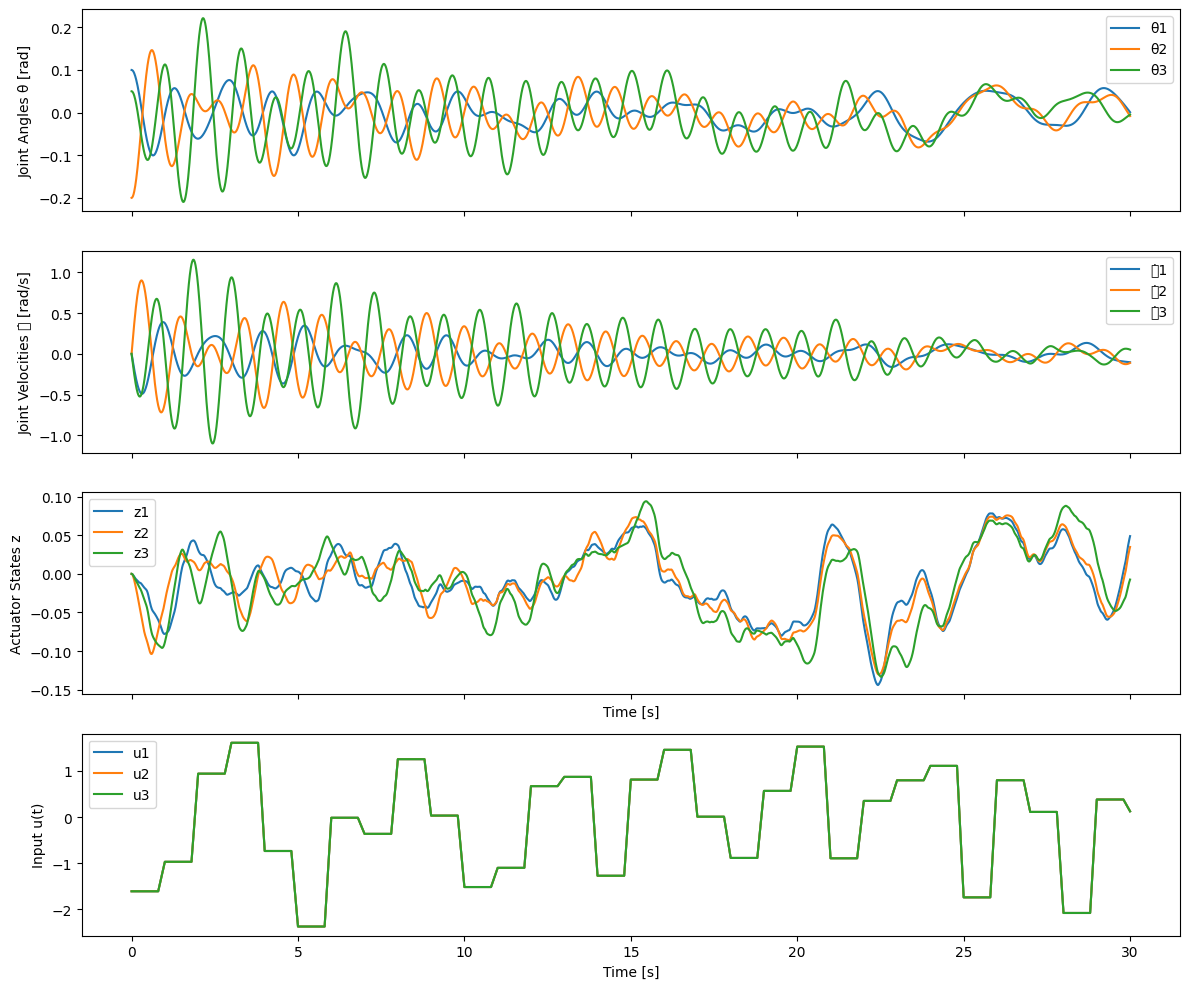

In [4]:
## Plot Gaussian

control_delta = 0.2
input_seq = GaussianSqWave(period=5)

u_values = input_seq.sample((0, T), control_delta)
time_u = np.linspace(0, T, len(u_values))

t3, y3 = simulate_realistic_input(input_seq)

# Plot results
fig, axs = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
axs[0].plot(t3, y3[0:3].T)
axs[0].set_ylabel("Joint Angles θ [rad]")
axs[0].legend(["θ1", "θ2", "θ3"])

axs[1].plot(t3, y3[3:6].T)
axs[1].set_ylabel("Joint Velocities 𝜃̇ [rad/s]")
axs[1].legend(["𝜃̇1", "𝜃̇2", "𝜃̇3"])

axs[2].plot(t3, y3[6:9].T)
axs[2].set_ylabel("Actuator States z")
axs[2].set_xlabel("Time [s]")
axs[2].legend(["z1", "z2", "z3"])

axs[3].plot(time_u, np.tile(u_values, (1, 3)))  
axs[3].set_ylabel("Input u(t)")
axs[3].set_xlabel("Time [s]")
axs[3].legend(["u1", "u2", "u3"])

plt.tight_layout()
plt.show()

C:\Users\g7fie\AppData\Local\Temp\ipykernel_21852\3632290219.py:31: UserWarning: Glyph 120579 (\N{MATHEMATICAL ITALIC SMALL THETA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


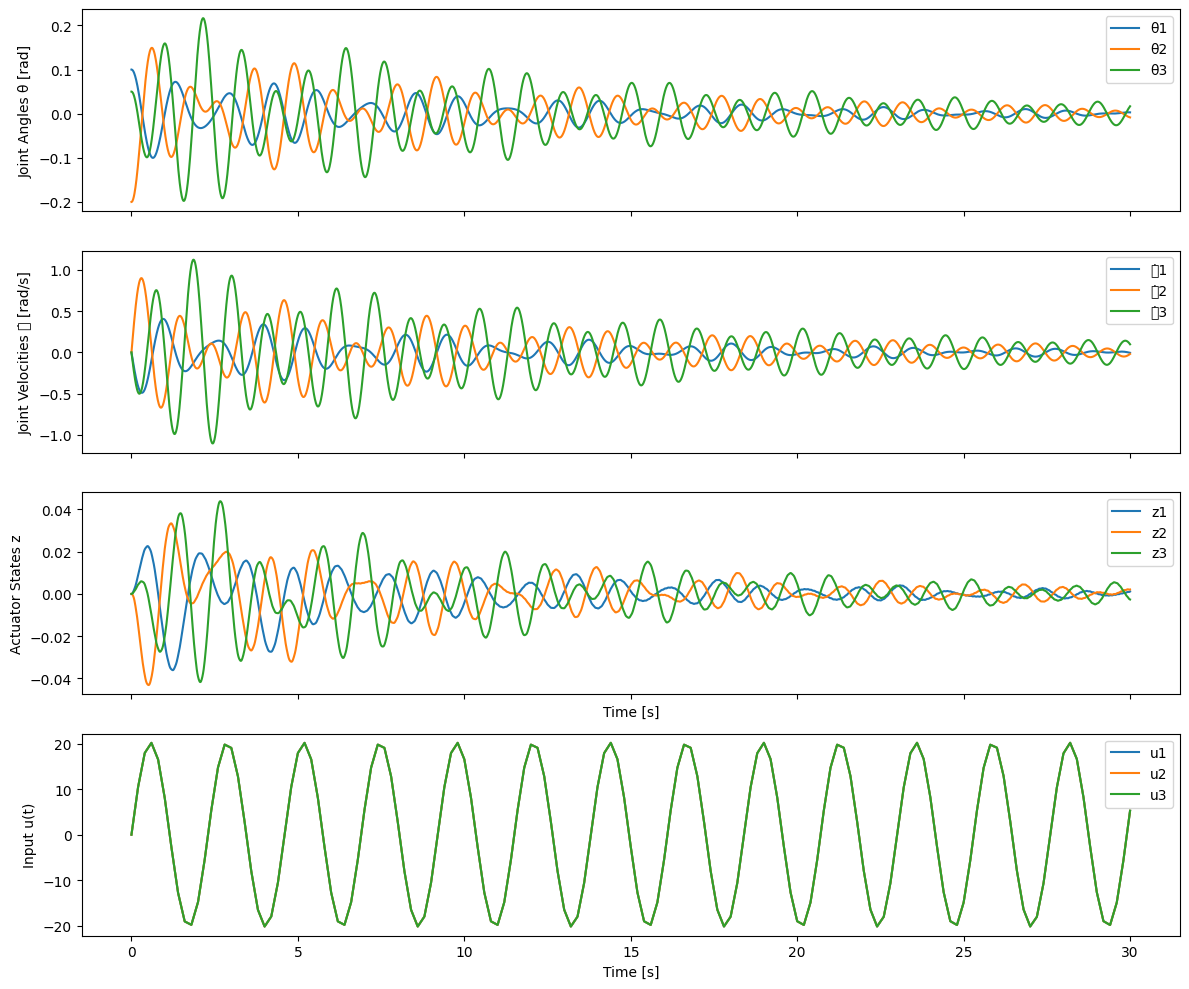

In [5]:
## Plot Sinusoidal

control_delta = 0.2
input_seq = SinusoidalSequence(max_freq=0.2)

u_values = input_seq.sample((0, T), control_delta)
time_u = np.linspace(0, T, len(u_values))

t3, y3 = simulate_realistic_input(input_seq)

# Plot results
fig, axs = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
axs[0].plot(t3, y3[0:3].T)
axs[0].set_ylabel("Joint Angles θ [rad]")
axs[0].legend(["θ1", "θ2", "θ3"])

axs[1].plot(t3, y3[3:6].T)
axs[1].set_ylabel("Joint Velocities 𝜃̇ [rad/s]")
axs[1].legend(["𝜃̇1", "𝜃̇2", "𝜃̇3"])

axs[2].plot(t3, y3[6:9].T)
axs[2].set_ylabel("Actuator States z")
axs[2].set_xlabel("Time [s]")
axs[2].legend(["z1", "z2", "z3"])

axs[3].plot(time_u, np.tile(u_values, (1, 3)))
axs[3].set_ylabel("Input u(t)")
axs[3].set_xlabel("Time [s]")
axs[3].legend(["u1", "u2", "u3"])

plt.tight_layout()
plt.show()